In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#for data preprocessing
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans

#for modeling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

#filter warnings
import warnings
warnings.filterwarnings("ignore")

import os
print(os.listdir("./datasets"))


from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

['loaded-res.txt', 'unloaded-res copy.txt', 'unloaded-res.csv', 'unloaded-res.txt', 'loaded-res.csv', 'loaded-res copy.txt', 'headers.csv']


In [59]:
df = pd.read_csv("./datasets/unloaded-res.csv")
df.head()



,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
0,2.000,500,499,192,293,423,3846,6852
1,3.000,500,501,182,257,312,666,2641
2,4.001,500,500,168,253,313,799,1718
3,5.000,500,500,172,226,277,513,1896
4,6.000,500,499,167,238,295,406,1214


In [60]:
df['time'] = df['time'].astype(int)
df.head()



,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
0,2,500,499,192,293,423,3846,6852
1,3,500,501,182,257,312,666,2641
2,4,500,500,168,253,313,799,1718
3,5,500,500,172,226,277,513,1896
4,6,500,499,167,238,295,406,1214


In [61]:
def read_dataset(filePath,delimiter=','):
    return genfromtxt(filePath, delimiter=delimiter)

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):

        predictions = (probs < epsilon) 
        #print(predictions)
        f = f1_score(gt, predictions,average='binary')
        #print(f)
        #print('------')
        if f > best_f1:
            #print('----')
            best_f1 = f
            best_epsilon = epsilon
    
    return best_f1, best_epsilon

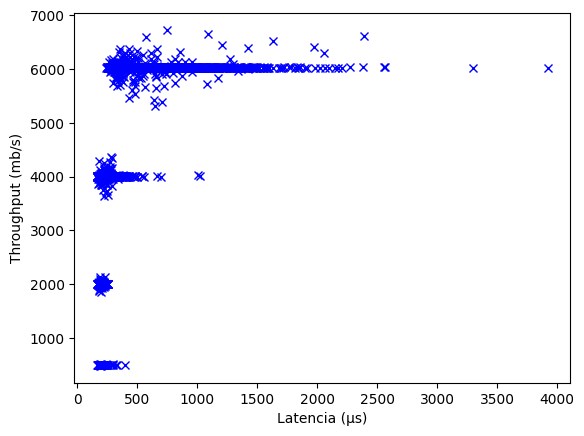

In [116]:
plt.xlabel('Latencia (µs)')
plt.ylabel('Throughput (mb/s)')
plt.plot(df['latency_median'],df['sent'],'bx')
plt.show()

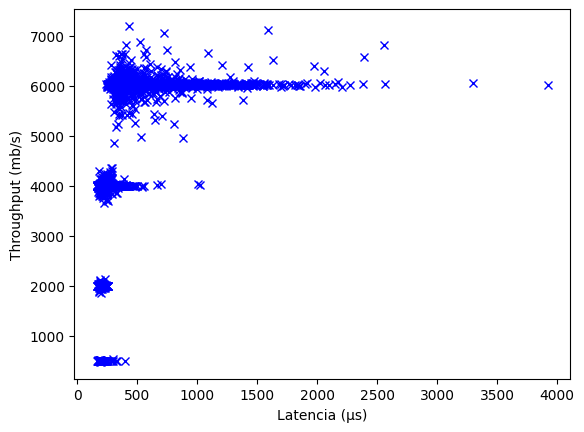

In [63]:
plt.xlabel('Latencia (µs)')
plt.ylabel('Throughput (mb/s)')
plt.plot(df['latency_median'],df['received'],'bx',)
plt.show()

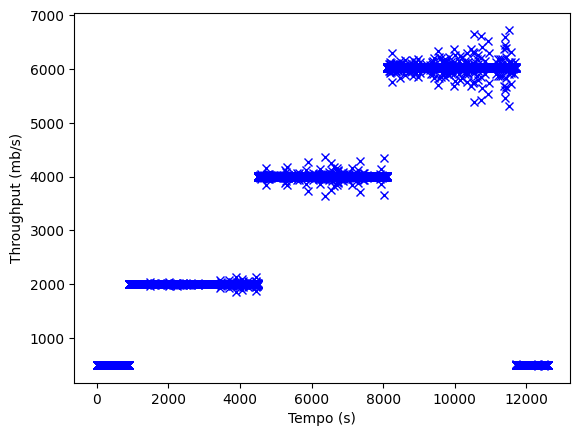

In [64]:
plt.xlabel('Tempo (s)')
plt.ylabel('Throughput (mb/s)')
plt.plot(df['time'],df['sent'],'bx',)
plt.show()

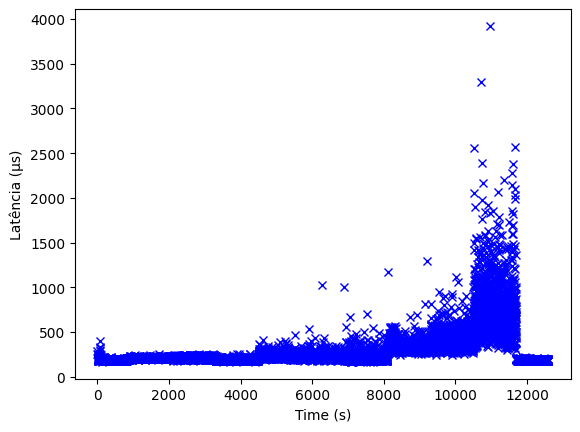

In [65]:
plt.xlabel('Time (s)')
plt.ylabel('Latência (µs)')
plt.plot(df['time'],df['latency_median'],'bx')
plt.show()

In [66]:
df_1 = df[['time', 'latency_median']]

df_1.head()

,time,latency_median
0,2,293
1,3,257
2,4,253
3,5,226
4,6,238


In [67]:
df_2 = df[['time', 'sent']]
df_2.head()

,time,sent
0,2,500
1,3,500
2,4,500
3,5,500
4,6,500


In [68]:
df_3 = df[['latency_median', 'sent']]
df_3.head()

,latency_median,sent
0,293,500
1,257,500
2,253,500
3,226,500
4,238,500


In [70]:
df_4 = df[['latency_median', 'received']]
df_4.head()

,latency_median,received
0,293,499
1,257,501
2,253,500
3,226,500
4,238,499


In [71]:
def getDistanceByPoint(data, model):
    # Inicializa uma lista para armazenar as distâncias
    distances = []

    for i in range(len(data)):
        Xa = np.array(data.loc[i])  # Ponto atual
        # Pega o centro do cluster correspondente
        Xb = model.cluster_centers_[model.labels_[i]]
        # Calcula a norma da diferença e adiciona à lista
        distances.append(np.linalg.norm(Xa - Xb))
    
    # Converte a lista para um Pandas Series
    return pd.Series(distances)

# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

### Latencia e Enviados

In [72]:
data = df_3

In [73]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

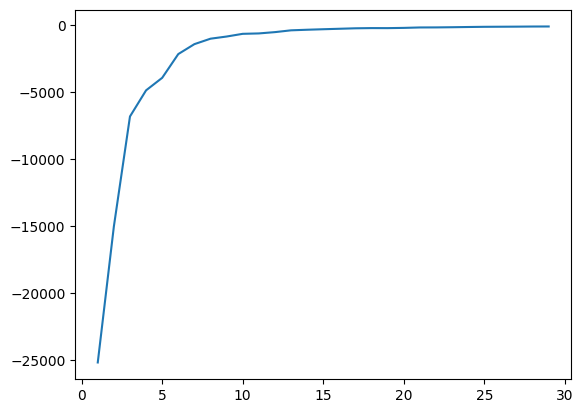

In [74]:
n_cluster = range(1, 30)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [82]:
df_3['cluster'] = kmeans[14].predict(data)
df_3['principal_feature1'] = data[0]
df_3['principal_feature2'] = data[1]
df_3['cluster'].value_counts()

cluster
4     3600
0     2459
1     1799
10    1128
14    1094
9      912
3      487
8      418
6      305
2      196
7      111
12      60
13      19
5        9
11       2
Name: count, dtype: int64

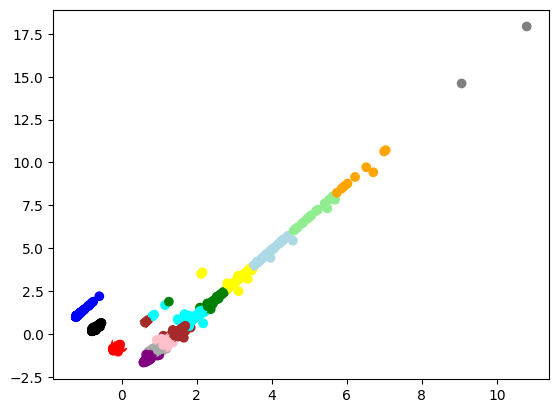

In [83]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df_3['principal_feature1'], df_3['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [106]:
outliers_fraction = 0.01

distance = getDistanceByPoint(data, kmeans[14])

distance = pd.Series(distance)

number_of_outliers = int(outliers_fraction * len(distance))

threshold = distance.nlargest(number_of_outliers).min()

df_3['anomaly21'] = (distance >= threshold).astype(int)

In [101]:
print(threshold)

0.6094428699784248


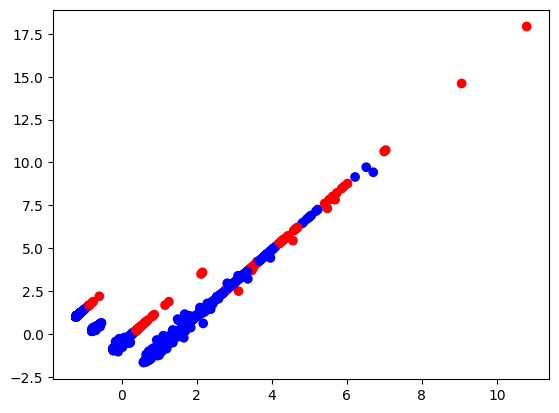

In [107]:
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df_3['principal_feature1'], df_3['principal_feature2'], c=df_3["anomaly21"].apply(lambda x: colors[x]))
plt.show()

In [110]:
df_3.head()

,latency_median,sent,cluster,principal_feature1,principal_feature2,anomaly21
0,293,500,1,-0.877694,1.645872,1
1,257,500,1,-0.977607,1.454027,0
2,253,500,1,-0.988709,1.432711,0
3,226,500,1,-1.063644,1.288827,0
4,238,500,1,-1.030340,1.352776,0


In [111]:
a = df_3.loc[df_3['anomaly21'] == 1, ['latency_median', 'sent']] #anomaly
a

,latency_median,sent
0,293,500
81,303,500
82,337,500
83,396,500
84,324,500
...,...,...
11658,2102,6023
11662,2570,6028
11670,1985,6019
11671,2027,6026


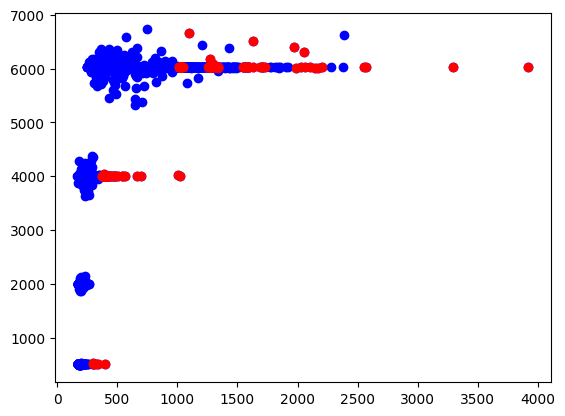

In [ ]:
fig, ax = plt.subplots()

a = df_3.loc[df_3['anomaly21'] == 1, ['latency_median', 'sent']] #anomaly

ax.scatter(df['latency_median'], df['sent'], color='blue')
ax.scatter(a['latency_median'],a['sent'], color='red')
plt.show()

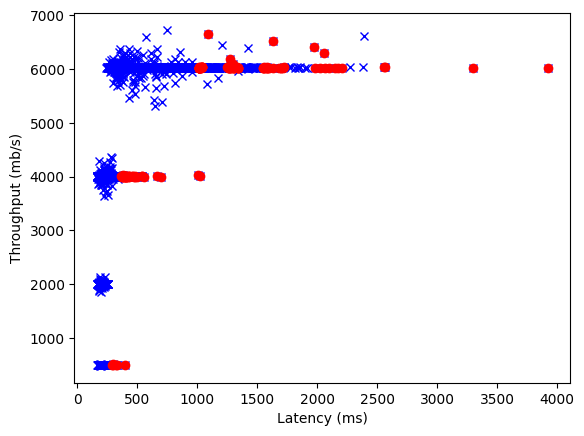

In [119]:
plt.figure()
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(df['latency_median'], df['sent'],'bx')
plt.plot(a['latency_median'],a['sent'],'ro')
plt.show()

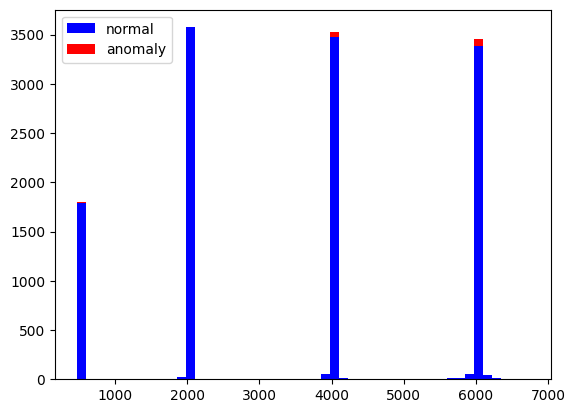

In [129]:
a = df.loc[df_3['anomaly21'] == 0, 'sent']
b = df.loc[df_3['anomaly21'] == 1, 'sent']

fig, axs = plt.subplots()
axs.hist([a,b], bins=50, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [ ]:
x1 = (df_3['sent'] <=18).astype(int)
x2= ((df_3['sent'] > 18) & (df['sent']<=21)).astype(int)
x3 = ((df_3['sent'] > 21) & (df['sent']<=24)).astype(int)
x4 = ((df_3['sent'] > 24) & (df['value']<=27)).astype(int)
x5 = (df_3['sent'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

In [135]:
outliers_fraction = 0.01

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df_3['anomaly25'] = pd.Series(model.predict(data))
df_3['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

anomaly25
0    12474
1      125
Name: count, dtype: int64


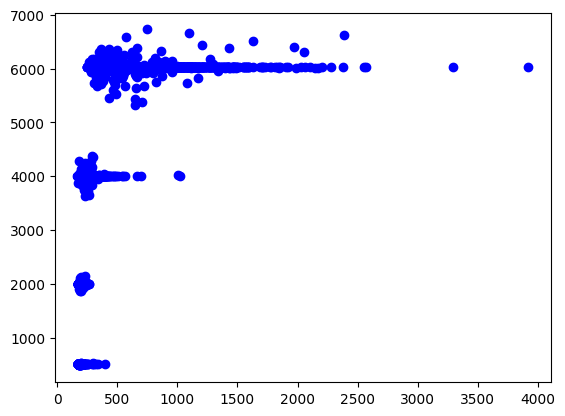

In [138]:
fig, ax = plt.subplots()

a = df_3.loc[df_3['anomaly25'] == 1, ['latency_median', 'sent']] #anomaly

ax.scatter(df['latency_median'], df['sent'], color='blue')
ax.scatter(a['latency_median'],a['sent'], color='red')
plt.show()

In [140]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df_3['anomaly26'] = pd.Series(model.predict(data))
df_3['anomaly26'] = df_3['anomaly26'].map( {1: 0, -1: 1} )
print(df_3['anomaly26'].value_counts())

anomaly26
0    12473
1      126
Name: count, dtype: int64


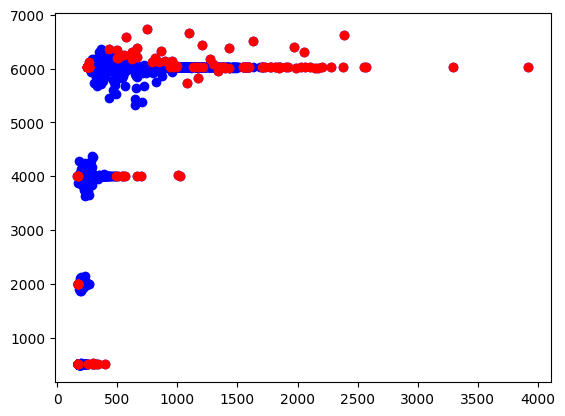

In [141]:
fig, ax = plt.subplots()

a = df_3.loc[df_3['anomaly26'] == 1, ['latency_median', 'sent']] #anomaly

ax.scatter(df['latency_median'], df['sent'], color='blue')
ax.scatter(a['latency_median'],a['sent'], color='red')
plt.show()

In [143]:
data_n = df[['latency_median', 'sent']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
# train data
x_train = data_n[0:-prediction_time-testdatacut].to_numpy()
y_train = data_n[prediction_time:-testdatacut][0].to_numpy()


# test data
x_test = data_n[0-testdatacut:-prediction_time].to_numpy()
y_test = data_n[prediction_time-testdatacut:  ][0].to_numpy()

In [144]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (11497, 50, 2)
y_train (11497,)
x_test (1000, 50, 2)
y_test (1000,)
